In [237]:
import pandas

pandas.set_option('display.max_rows', None, 'display.max_columns', None)
spending_data = pandas.read_csv('../data/csv/cabinet_member_spending.csv')
cabinet_data = pandas.read_csv('../data/csv/cabinet.csv')
index_fund_data = pandas.read_csv('../data/csv/snp500.csv')

### First, we will import the data and process it to hold the percentages we need, in addition to cleaning the DJI data

In [238]:
import datetime
import math

REPUBLICAN_PRESIDENTS = ('George W. Bush', 'Donald Trump')
DEMOCRATIC_PRESIDENTS = ('Barack Obama', )
REPUBLICAN_PARTY = 0
DEMOCRATIC_PARTY = 1

normalized_spending_data = pandas.DataFrame(columns=['party', 'department', 'name', 'vote_ratio', 'confirmed_date' 'domestic_spending_ratio'])
normalized_spending_data = normalized_spending_data.assign(
    party=spending_data['President'].map(lambda president: REPUBLICAN_PARTY if president in REPUBLICAN_PRESIDENTS else DEMOCRATIC_PARTY),
    department=spending_data['Department'],
    name=spending_data['Nominee'],
    vote_ratio=spending_data['Votes For']/(spending_data['Votes For'] + spending_data['Votes Against']),
    domestic_spending=spending_data['domestic_spending'],
    foreign_spending=spending_data['foreign_spending']
)

index_fund_data['Date'] = index_fund_data['Date'].apply(lambda date: datetime.datetime.strptime(date, '%m/%d/%y'))
cabinet_data = cabinet_data[cabinet_data['Confirmed'].apply(lambda x: not (isinstance(x, float) and math.isnan(x)))]

### For each cabinet member, we will find the average price of the SNP during their tenure

In [239]:
import itertools
import datetime

# Taken from: https://stackoverflow.com/a/6822773
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(itertools.islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

    # Ensure that we get an extra one including the last one to present
    yield result[1:] + (None,)


for position in cabinet_data['Position'].unique():
    rows_to_iterate = cabinet_data[cabinet_data['Position'] == position]
    for row1, row2 in window(rows_to_iterate.iterrows()):
        _, row1 = row1
        _, row2 = (None, row2) if row2 is None else row2

        member = row1['Nominee']
        # The ending date of this nominee is the 
        start_date = row1['Confirmed']
        end_date = pandas.Timestamp(datetime.datetime.now()) if row2 is None else row2['Confirmed']

        res = index_fund_data[
            (index_fund_data['Date'] >= start_date)
        ]
        index_average = index_fund_data[
            (index_fund_data['Date'] >= start_date) &
            (index_fund_data['Date'] <= end_date)
        ]['Close'].mean()
        normalized_spending_data.loc[normalized_spending_data['name'] == member, 'index_average'] = index_average
        normalized_spending_data.loc[normalized_spending_data['name'] == member, 'confirmed_date'] = start_date

## Correlations between index average and domestic spending amounts 

In [240]:
import scipy.stats

sorted_spending_data = normalized_spending_data.sort_values(by=['confirmed_date'])

pearson_r, pearson_p = scipy.stats.pearsonr(sorted_spending_data['index_average'], sorted_spending_data['domestic_spending'])
spearman_r, spearman_p = scipy.stats.spearmanr(sorted_spending_data['index_average'], sorted_spending_data['domestic_spending'])

print(f'Pearson r-value: {pearson_r:0.3}\nPearson p-value: {pearson_p:0.3}')
print('')
print(f'Spearman r-value: {spearman_r:0.3}\nSpearman p-value: {spearman_p:0.3}')

Pearson r-value: -0.0338
Pearson p-value: 0.757

Spearman r-value: 0.0794
Spearman p-value: 0.467


## Correlations between index average and foreign spending amounts 

In [241]:
import scipy.stats

sorted_spending_data = normalized_spending_data.sort_values(by=['confirmed_date'])

pearson_r, pearson_p = scipy.stats.pearsonr(sorted_spending_data['index_average'], sorted_spending_data['foreign_spending'])
spearman_r, spearman_p = scipy.stats.spearmanr(sorted_spending_data['index_average'], sorted_spending_data['foreign_spending'])

print(f'Pearson r-value: {pearson_r:0.3}\nPearson p-value: {pearson_p:0.3}')
print('')
print(f'Spearman r-value: {spearman_r:0.3}\nSpearman p-value: {spearman_p:0.3}')

Pearson r-value: -0.0389
Pearson p-value: 0.722

Spearman r-value: 0.0397
Spearman p-value: 0.717


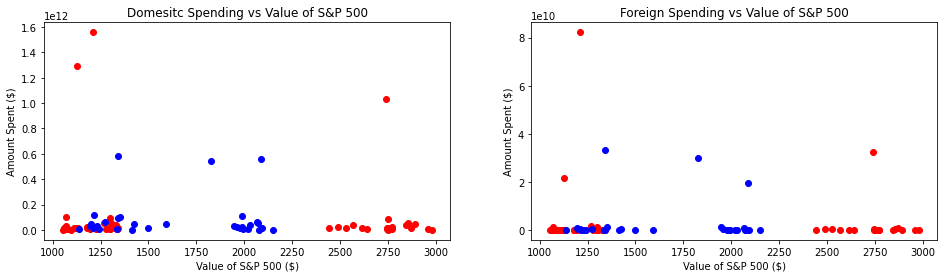

In [242]:
from matplotlib import pyplot as plt

def plot_spending(axes: plt.Axes, column: str):
    for party in sorted_spending_data['party'].unique():
        party_spending_data = sorted_spending_data[sorted_spending_data['party'] == party]
        axes.scatter(party_spending_data['index_average'], party_spending_data[column], c='red' if party == REPUBLICAN_PARTY else 'blue')\
        
figure = plt.figure(figsize=(16,4))
domestic_plot = figure.add_subplot(1, 2, 1)
domestic_plot.set_title('Domesitc Spending vs Value of S&P 500')
domestic_plot.set_xlabel('Value of S&P 500 ($)')
domestic_plot.set_ylabel('Amount Spent ($)')
plot_spending(domestic_plot, 'domestic_spending')

foreign_plot = figure.add_subplot(1, 2, 2)
foreign_plot.set_title('Foreign Spending vs Value of S&P 500')
foreign_plot.set_xlabel('Value of S&P 500 ($)')
foreign_plot.set_ylabel('Amount Spent ($)')
plot_spending(foreign_plot, 'foreign_spending')

plt.show()

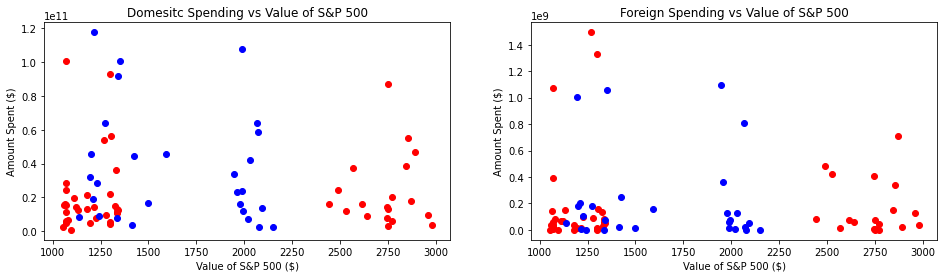

In [243]:
from matplotlib import pyplot as plt

sorted_spending_data = sorted_spending_data[sorted_spending_data['department'] != 'DEPARTMENT OF DEFENSE (DOD)']

def plot_spending(axes: plt.Axes, column: str):
    for party in sorted_spending_data['party'].unique():
        party_spending_data = sorted_spending_data[sorted_spending_data['party'] == party]
        axes.scatter(party_spending_data['index_average'], party_spending_data[column], c='red' if party == REPUBLICAN_PARTY else 'blue')\
        
figure = plt.figure(figsize=(16,4))
domestic_plot = figure.add_subplot(1, 2, 1)
domestic_plot.set_title('Domesitc Spending vs Value of S&P 500 (Omitting DOD)')
domestic_plot.set_xlabel('Value of S&P 500 ($)')
domestic_plot.set_ylabel('Amount Spent ($)')
plot_spending(domestic_plot, 'domestic_spending')

foreign_plot = figure.add_subplot(1, 2, 2)
foreign_plot.set_title('Foreign Spending vs Value of S&P 500  (Omitting DOD)')
foreign_plot.set_xlabel('Value of S&P 500 ($)')
foreign_plot.set_ylabel('Amount Spent ($)')
plot_spending(foreign_plot, 'foreign_spending')

plt.show()